# Investigation of citibike ridership with income

# Objective: relate the citibike ridership to income.
### 1. Download two months of citibike data 
### 2. Download income information fron IRS for NYC
### 3. Find the zipcodes of citibike stations by reverse geocoding the coordinates
### 4. Find the number of rides per zipcodes in one of your 2 months of data
### 5. Fit a line to ridership (number of rides over one of the 2 months of citibike data downloaded) vs income (total for the zip) and income per person for that zip
### 6. Improve the fit by removing 2 outliers and quantify the improvement
### 7. Fit a 2nd degree polynomial to the same data
### 8. Compare FORMALLY the line adn the 2nd degree polynomial fit with LR test to assess which is a better fit to your chosen significance level.

## Extra Credit

### 1. Compare the income to the incomePC as endogenous variable. How do the fit compare? If it is better what does this say? If it is worse, wht does this say? Discuss why it may be and if you have an explaination describe how  you would test it. If you have time go ahead and test it too!

### 2. Repeat the analysis with another dataset. Are the results consistent?


## 1. Download two months of citibike data: 201501 and another month of your choice. Begin working with 201501, and if you have time (extra credit) you will repeat the analysis for the other month, to see if your conclusions are robust. 

In [35]:
import os
import pandas as pd
import numpy as np
import pylab as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from getCitiBikeCSV import getCitiBikeCSV # they have access to this function which I wrote. 
from get_jsonparsed_data import getJsonParsedData # i give them this function


# they must move the data to a directory $PUIDATA (pointed to by an envaironmental variable)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:

getCitiBikeCSV("201501")
cb2016 = pd.read_csv(os.getenv("PUIDATA") + "/" + "201601-citibike-tripdata.csv")

file in place, you can continue


In [3]:
getCitiBikeCSV("201506")
cb2015 = pd.read_csv(os.getenv("PUIDATA") + "/" + "201506-citibike-tripdata.csv")

file in place, you can continue


In [4]:
cb2016.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958,1
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969,1
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982,2
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961,2
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952,1


## 2. Downloading income data from IRS 

### Find income data : you can find it from IRS the file name is  14zp33ny 
### and the IRS site is https://www.irs.gov/pub/irs-soi/?C=N;O=D

Use the Adjusted gross income for every zipcode. Additionally identify the columns indicating the number of returns, the number of dependents, the number of joint returns. Together they indicate the size of the family, allowing you to obtain the income per person from the income of the whole zipcode. 

Convert the zip tp numeric values (with pd.to_numeric)

For every zipcode the adjusted median income is the first valid row associated with that zipcode. 

If you need help look here [...]

Store the income data in a daraframe with (at least) the columns 

**zipcodes,	income, N,	incomePC**

where zipcodes are the zipcodes, income is the AGI, N the number of returns, incomePC the AGI for the zipcode divided by (N + Ndeoendents + Njoint returns)

In [5]:
#i require the data to be moved to PUIDATA, which has to be a directory linked tot he env var PUIDATA
#!curl -O https://www.irs.gov/pub/irs-soi/14zp33ny.xls
#os.system("mv 14zp33ny.xls " + os.getenv("PUIDATA"))
#incomeByZip = pd.read_excel(os.getenv("PUIDATA") + "/14zp33ny.xls", header=3, index_col="""ZIP\ncode [1]""")
incomeByZip = pd.read_excel("https://www.irs.gov/pub/irs-soi/14zp33ny.xls", header=3, index_col="""ZIP\ncode [1]""")
incomeByZip.head


<bound method NDFrame.head of                                                    Size of adjusted gross income  \
ZIP\ncode [1]                                                                      
NaN                                                                          NaN   
NaN                                                                          NaN   
0                                                                          Total   
0                                                               $1 under $25,000   
0                                                          $25,000 under $50,000   
0                                                          $50,000 under $75,000   
0                                                         $75,000 under $100,000   
0                                                        $100,000 under $200,000   
0                                                               $200,000 or more   
NaN                                           

In [6]:
#extract the right entry with iloc[0]: e.g.
print (incomeByZip.loc[[10001]]["Adjusted gross income (AGI) [3]"].iloc[0])

2363960.0


In [7]:
zipcs = pd.to_numeric(incomeByZip.index, errors='coerce')
zipcs = zipcs[~np.isnan(zipcs)].astype(int)

Create a new dataframe with the value of income per zipcode, and income per person per zipcode 
(income per person = income / (Nreturns + Njoint returns + Ndependents)

In [8]:
zipincome = pd.DataFrame()
zipincome['zipcodes'] = list(set(zipcs))
zipincome['income'] = [incomeByZip.loc[[z]]["Adjusted gross income (AGI) [3]"].iloc[0] for z in set(zipcs)]
zipincome['N'] = [incomeByZip.loc[[z]]["Number of returns"].iloc[0] for z in set(zipcs)]
zipincome['Njoint'] = [incomeByZip.loc[[z]]["Number of joint returns"].iloc[0] for z in set(zipcs)]
zipincome['Ndeps'] = [incomeByZip.loc[[z]]["Number of dependents"].iloc[0] for z in set(zipcs)]


In [9]:
#income per person in zipcode
zipincome['incomePC'] = zipincome['income'] / (zipincome.N + zipincome.Ndeps + zipincome.Njoint)

In [10]:
zipincome.head()

,zipcodes,income,N,Njoint,Ndeps,incomePC
0,0,766646080,9397410,2942890,5539120,42.878688
1,99999,14338084,88940,28130,43810,89.122849
2,10001,2363960,14080,2410,3250,119.754813
3,10002,2215542,43370,11040,19160,30.114748
4,10003,6910992,29810,5460,4790,172.516026


## 3. Find the zipcodes of citibike stations by reverse geocoding the coordinates
You can use the google API including the long and latitide of each station: CAREFULL!!: you do not need a separate API query per ride, just one per each citibike station! You have a limit of 2500 requests/day, so you cannot submit a request per ride. (You can use pd.DataFrame.drop_duplicates, for example, to identify identical coordinate pairs or identical station ids)

https://developers.google.com/maps/documentation/geocoding/intro

If you do not have an API key for googlemaps you can get one instantly here
https://developers.google.com/maps/documentation/geocoding/get-api-key


Once you have the zip for a lat/lon pair (lat, lon) you can use a condition like 
```
(cb['start station latitude'] == lat) * (cb['start station longitude'] == lon)
```
as index to identify the rows of the citibike datframe that contain those coordinates and are associated to that zipcode
```
cb['zipcodes']['start station latitude'] == lat) * (cb['start station longitude'] == lon)] = thatzipcode
```

If you are not up for that you can download the zipcode of each citibike station here 
http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationzips.json
However, this will cost you 0.5/10 points.


In [12]:
cb2015['zipcodes'] = np.zeros(len(cb2015))
for latlon in cb2015[['start station latitude', 
                'start station longitude']].drop_duplicates().values:
    url = ("https://maps.googleapis.com/maps/api/geocode/json?latlng=" +
           "%f,%f&key=%s"%(
            latlon[0], latlon[1], os.getenv('GOOGLEAPI')))
    revgeo = getJsonParsedData(url)["results"][0]['address_components'][-1]
    cb2015['zipcodes'][(cb2015['start station latitude'] == latlon[0]) * 
           (cb2015['start station longitude'] == latlon[1])] = revgeo['long_name']
cb2015.head()

//anaconda/lib/python3.5/site-packages/pandas/computation/expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/pandas/core/internals.py:4417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  comp = (nn == nn_at)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,zipcodes
0,1338,6/1/2015 0:00,6/1/2015 0:22,128,MacDougal St & Prince St,40.727103,-74.002971,2021,W 45 St & 8 Ave,40.759291,-73.988597,20721,Subscriber,1984,1,2926
1,290,6/1/2015 0:00,6/1/2015 0:05,438,St Marks Pl & 1 Ave,40.727791,-73.985649,312,Allen St & E Houston St,40.722055,-73.989111,21606,Subscriber,1997,1,10003
2,634,6/1/2015 0:01,6/1/2015 0:11,383,Greenwich Ave & Charles St,40.735238,-74.000271,388,W 26 St & 10 Ave,40.749718,-74.002950,16595,Subscriber,1993,1,10011
3,159,6/1/2015 0:01,6/1/2015 0:04,361,Allen St & Hester St,40.716059,-73.991908,531,Forsyth St & Broome St,40.718939,-73.992663,16949,Subscriber,1981,1,5416
4,1233,6/1/2015 0:02,6/1/2015 0:22,382,University Pl & E 14 St,40.734927,-73.992005,532,S 5 Pl & S 4 St,40.710451,-73.960876,17028,Customer,NaN,0,4510


In [13]:
#grouping and counting
cbgroup = cb2015.groupby('zipcodes', as_index=False).count()
cbgroup.head()

,zipcodes,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,0914,3675,3675,3675,3675,3675,3675,3675,3675,3675,3675,3675,3675,3675,3369,3675
1,10001,51691,51691,51691,51691,51691,51691,51691,51691,51691,51691,51691,51691,51691,45571,51691
2,10002,45970,45970,45970,45970,45970,45970,45970,45970,45970,45970,45970,45970,45970,40795,45970
3,10003,74663,74663,74663,74663,74663,74663,74663,74663,74663,74663,74663,74663,74663,67536,74663
4,10004,13698,13698,13698,13698,13698,13698,13698,13698,13698,13698,13698,13698,13698,9850,13698


In [14]:
cbgroup.columns

Index(['zipcodes', 'tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [15]:
# dropping unneded data
cbgroup.drop([ 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'], axis=1, inplace=True)

In [16]:
# renaming columns. Notice I use a column that should have no NaNs
cbgroup.rename(columns = {'tripduration':'Nrides'}, inplace=True)

In [17]:
cbgroup.head()

,zipcodes,Nrides
0,0914,3675
1,10001,51691
2,10002,45970
3,10003,74663
4,10004,13698


# MERGE
notice there may be lots of invalid zipcodes from bad reverse geocoding!! Drop all data w zipcodes > 1000

In [18]:
#NOTE: the zipcodes have to be numbers in both DFs
cbgroup['zipcodes'] = cbgroup['zipcodes'].astype(float)

In [19]:
cbincome = pd.merge(zipincome, cbgroup, how="inner", on="zipcodes")

In [20]:
cbincome.head()

,zipcodes,income,N,Njoint,Ndeps,incomePC,Nrides
0,10001,2363960,14080,2410,3250,119.754813,51691
1,10002,2215542,43370,11040,19160,30.114748,45970
2,10003,6910992,29810,5460,4790,172.516026,74663
3,10004,925417,2540,840,1130,205.192239,13698
4,10005,5545849,5890,1340,1340,647.123571,9631


# 5. Plot and fit the data

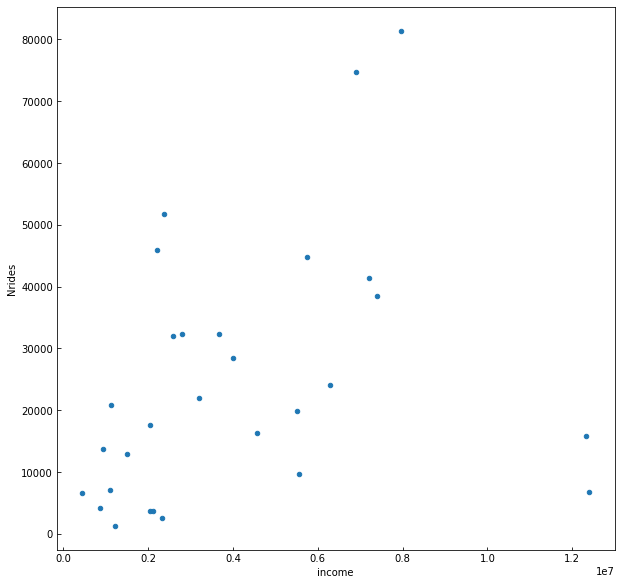

In [21]:
cbincome.plot(kind="scatter", x='income', y='Nrides', figsize=(10,10))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.096
Date:                Mon, 24 Oct 2016   Prob (F-statistic):             0.0898
Time:                        03:08:07   Log-Likelihood:                -327.22
No. Observations:                  29   AIC:                             658.4
Df Residuals:                      27   BIC:                             661.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.609e+04   6076.349      2.647      0.013      3618.430  2.86e+04
income         0.0021      0.001      1.760      0.090        -0.000     0.004
==============================================================================
Omnibus:                        4.546   Durbin-Watson:                   1.204
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                3.174
Skew:                           0.790   Prob(JB):                        0.205
Kurtosis:                       3.365   Cond. No.                     8.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

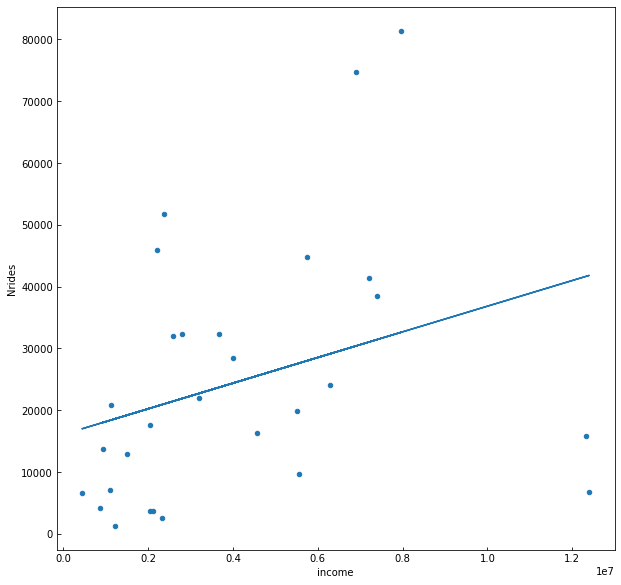

In [79]:
linmodel_income = smf.ols(formula = "Nrides ~ income", data=cbincome).fit()
ax = cbincome.plot(kind="scatter", x='income', y='Nrides', figsize=(10,10))
ax.plot(cbincome.income, linmodel_income.predict(), '-')
linmodel_income.summary()

# 6. choosing two high leverage points, Can be done by eye or with an influence plot

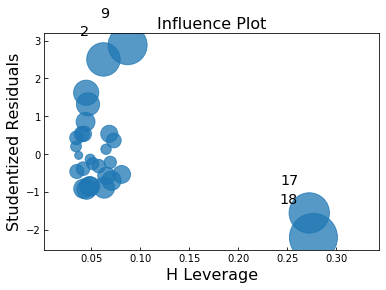

In [36]:
tmp = sm.graphics.influence_plot(linmodel_income)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     18.86
Date:                Mon, 24 Oct 2016   Prob (F-statistic):           0.000204
Time:                        02:30:56   Log-Likelihood:                -299.01
No. Observations:                  27   AIC:                             602.0
Df Residuals:                      25   BIC:                             604.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4743.9628   5716.993      0.830      0.415     -7030.404  1.65e+04
income         0.0060      0.001      4.343      0.000         0.003     0.009
==============================================================================
Omnibus:                        1.855   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.396   Jarque-Bera (JB):                1.558
Skew:                           0.562   Prob(JB):                        0.459
Kurtosis:                       2.651   Cond. No.                     7.59e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

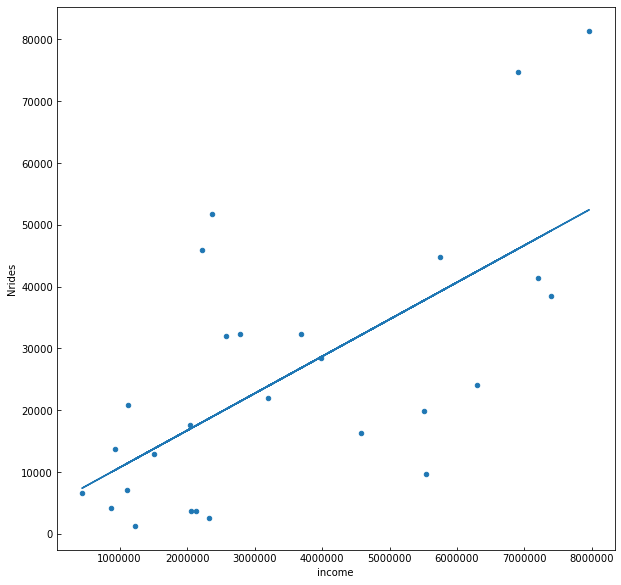

In [41]:
linmodel2_income = smf.ols(formula = "Nrides ~ income", data=cbincome.drop([17,18])).fit()
ax = cbincome.drop([17,18]).plot(kind="scatter", x='income', y='Nrides', figsize=(10,10))
ax.plot(cbincome.drop([17,18]).income, linmodel2_income.predict(), '-')
linmodel2_income.summary()

# the fit improved significantly going fron an explained variance of 7% to 40%

# 7. Fit a 2nd degree polynomial and assess if the addition of the extra parameter is justified by the data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     9.716
Date:                Mon, 24 Oct 2016   Prob (F-statistic):           0.000811
Time:                        02:39:06   Log-Likelihood:                -298.59
No. Observations:                  27   AIC:                             603.2
Df Residuals:                      24   BIC:                             607.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept         1.219e+04   1.03e+04      1.181      0.249     -9105.453  3.35e+04
income               0.0006      0.006      0.095      0.925        -0.013     0.014
I((income) ** 2)  6.563e-10   7.55e-10      0.869      0.394     -9.03e-10  2.22e-09
==============================================================================
Omnibus:                        2.256   Durbin-Watson:                   1.101
Prob(Omnibus):                  0.324   Jarque-Bera (JB):                1.966
Skew:                           0.620   Prob(JB):                        0.374
Kurtosis:                       2.543   Cond. No.                     8.43e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.43e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

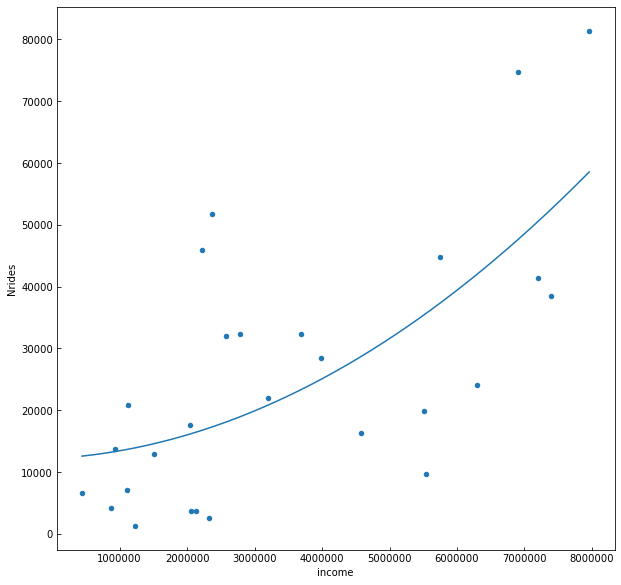

In [54]:
curvmodel2_income = smf.ols(formula = "Nrides ~ income + I((income)**2)", data=cbincome.drop([17,18])).fit()
ax = cbincome.drop([17,18]).plot(kind="scatter", x='income', y='Nrides', figsize=(10,10))
x = np.linspace(cbincome.drop([17,18]).income.min(), cbincome.drop([17,18]).income.max(), 1000)
ax.plot(x, curvmodel2_income.predict(exog = dict(income=x)), '-')
curvmodel2_income.summary()

# the adjusted R^2 did not improved 
# yet, to test if the more complex model is justifies we use the likelihood ratio test, with significance alpha=0.05

In [57]:
alpha = 0.05
LR = curvmodel2_income.compare_lr_test(linmodel2_income)

print ("We ", end="")
if LR[0] < 3.84: #0.05 level for 1 DOF chi sq distribution 
    print ("CANNOT") 
    
print ("reject the Null hypothesis that the restricted (linear) " + 
       "model is better than the 2nd degree polynomial fit with p-value ", end="")
print ("p < %.3f"%alpha)


We CANNOT
reject the Null hypothesis that the restricted (linear) model is better than the 2nd degree polynomial fit with p-value p < 0.050


# Test the Income per person

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.036
Method:                 Least Squares   F-statistic:                   0.02384
Date:                Mon, 24 Oct 2016   Prob (F-statistic):              0.878
Time:                        02:33:23   Log-Likelihood:                -328.78
No. Observations:                  29   AIC:                             661.6
Df Residuals:                      27   BIC:                             664.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.373e+04   6651.852      3.568      0.001      1.01e+04  3.74e+04
incomePC       4.6298     29.982      0.154      0.878       -56.889    66.149
==============================================================================
Omnibus:                        9.152   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                7.590
Skew:                           1.173   Prob(JB):                       0.0225
Kurtosis:                       3.883   Cond. No.                         378.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

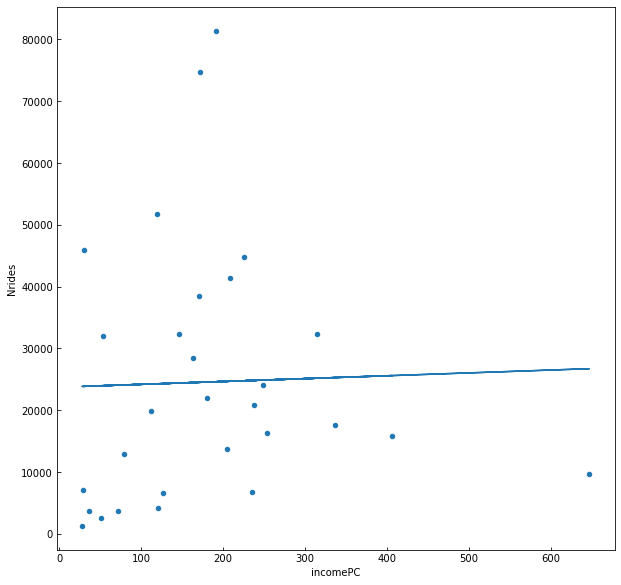

In [47]:
ax = cbincome.plot(kind="scatter", x='incomePC', y='Nrides', figsize=(10,10))
linmodel_incomePC = smf.ols(formula = "Nrides ~ incomePC", data=cbincome).fit()
ax.plot(cbincome.incomePC, linmodel_incomePC.predict(), '-')
linmodel_incomePC.summary()

# the fit is worse. This suggests that the number of rides may be correlated to the number of people in the zipcode. 
# this can be tested by lookiung the number of stations per zipcode.

In [95]:
stid2zip = getJsonParsedData("http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/stationzips.json")
stid2zip

{'116': 10011,
 '119': 11205,
 '137': 10022,
 '144': 11201,
 '147': 10282,
 '150': 10009,
 '151': 10012,
 '152': 10007,
 '153': 10016,
 '157': 11201,
 '160': 10016,
 '161': 10012,
 '168': 10011,
 '195': 10045,
 '2001': 11201,
 '2003': 10009,
 '2004': 10013,
 '2005': 11249,
 '2006': 10019,
 '2008': 10004,
 '2010': 10013,
 '2012': 10016,
 '2017': 10017,
 '2021': 10036,
 '2022': 10022,
 '2023': 10022,
 '212': 10011,
 '216': 11201,
 '217': 11201,
 '223': 10011,
 '224': 10038,
 '225': 10014,
 '228': 10017,
 '229': 10012,
 '232': 11201,
 '233': 11201,
 '236': 10003,
 '237': 10003,
 '238': 10014,
 '239': 11201,
 '243': 11217,
 '244': 11205,
 '245': 11205,
 '248': 10013,
 '250': 10012,
 '251': 10012,
 '252': 10011,
 '253': 10011,
 '254': 10011,
 '259': 10004,
 '260': 10004,
 '261': 11201,
 '263': 10013,
 '264': 10038,
 '265': 10002,
 '266': 10009,
 '267': 10018,
 '268': 10013,
 '270': 11205,
 '275': 11238,
 '276': 10013,
 '278': 11201,
 '279': 10038,
 '280': 10003,
 '281': 10019,
 '284': 10014

In [96]:
cb2016['zipcodes'] = cb2016['start station id'].astype(str).map(stid2zip)

In [97]:
cbgroup16 = cb2016.groupby('zipcodes', as_index=False).count()
cbgroup16.head()
cbgroup16['zipcodes'] = cbgroup16['zipcodes'].astype(float)
cbgroup16.rename(columns = {'tripduration':'Nrides'}, inplace=True)
cbincome16 = pd.merge(zipincome, cbgroup16, how="inner", on="zipcodes")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Nrides   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     4.259
Date:                Mon, 24 Oct 2016   Prob (F-statistic):             0.0456
Time:                        03:35:45   Log-Likelihood:                -442.33
No. Observations:                  42   AIC:                             888.7
Df Residuals:                      40   BIC:                             892.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5805.4982   2232.694      2.600      0.013      1293.056  1.03e+04
income         0.0009      0.000      2.064      0.046      1.75e-05     0.002
==============================================================================
Omnibus:                       16.024   Durbin-Watson:                   0.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.032
Skew:                           1.400   Prob(JB):                     0.000121
Kurtosis:                       4.570   Cond. No.                     8.43e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

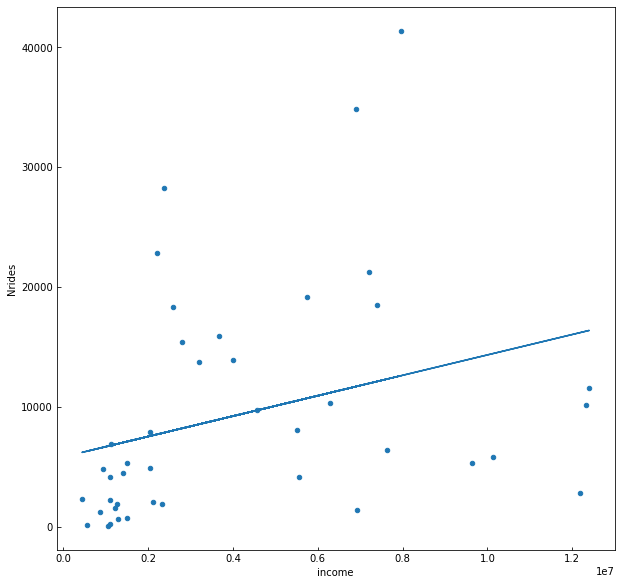

In [98]:
linmodel16_income = smf.ols(formula = "Nrides ~ income", data=cbincome16).fit()
ax = cbincome16.plot(kind="scatter", x='income', y='Nrides', figsize=(10,10))
ax.plot(cbincome16.income, linmodel16_income.predict(), '-')
linmodel16_income.summary()

In [99]:
cb2016.head()


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,zipcodes
0,923,1/1/2016 00:00:41,1/1/2016 00:16:04,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22285,Subscriber,1958,1,10013
1,379,1/1/2016 00:00:45,1/1/2016 00:07:04,476,E 31 St & 3 Ave,40.743943,-73.979661,498,Broadway & W 32 St,40.748549,-73.988084,17827,Subscriber,1969,1,10016
2,589,1/1/2016 00:00:48,1/1/2016 00:10:37,489,10 Ave & W 28 St,40.750664,-74.001768,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,21997,Subscriber,1982,2,10001
3,889,1/1/2016 00:01:06,1/1/2016 00:15:56,268,Howard St & Centre St,40.719105,-73.999733,3002,South End Ave & Liberty St,40.711512,-74.015756,22794,Subscriber,1961,2,10013
4,1480,1/1/2016 00:01:12,1/1/2016 00:25:52,2006,Central Park S & 6 Ave,40.765909,-73.976342,2006,Central Park S & 6 Ave,40.765909,-73.976342,14562,Subscriber,1952,1,10019
